## XG + LOF + OS

In [17]:
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
import xgboost as xgb
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from numpy import loadtxt
from numpy import sort
from numpy import mean
from sklearn.metrics import cohen_kappa_score
#from autoimpute.imputations import MultipleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


from sklearn.impute import SimpleImputer 
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut
from collections import Counter
from sklearn.metrics import f1_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support,classification_report,confusion_matrix, precision_recall_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [18]:
df = pd.read_excel("Updated_UKBioBank.xlsx")
## Data Pre-processing

In [19]:
# specific to UK BioBank dataset
class PreProcessing:
    def __init__(self, df):
        self.df = df
        
    def cleaning(self):
        new_df = self.df.copy()
        new_df = new_df.iloc[:, new_df.columns != 'QTrest']
        new_df = new_df[~((new_df['AF']==1) & (new_df['Arr']==1))] # remove overlaps
        imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
        new_df = pd.DataFrame(imp.fit_transform(new_df), columns=new_df.columns)
        new_df.loc[(new_df['Arr'] == 1) | (new_df['AF'] == 1), 'Disease'] = 1
        new_df.loc[(new_df['Arr'] == 0) & (new_df['AF'] == 0), 'Disease'] = 0
        self.df = new_df
        return self.df
    
    def getTrainTestSet(self):
        new_df = self.cleaning()
        choosing_samples_AF = new_df[new_df['AF'] == 1]
        choosing_samples_Arr =  new_df[new_df['Arr'] == 1]
        healthy_samples = new_df[new_df['Disease'] == 0]
        
        AF_x = choosing_samples_AF.loc[:,choosing_samples_AF.columns != 'Disease']
        AF_y = choosing_samples_AF['Disease']
        
        Arr_x = choosing_samples_Arr.loc[:,choosing_samples_Arr.columns != 'Disease']
        Arr_y = choosing_samples_Arr['Disease']
        
        healthy_x = healthy_samples.loc[:,healthy_samples.columns != 'Disease']
        healthy_y = healthy_samples['Disease']
        
        
        AF_X_train, AF_X_test, AF_y_train, AF_y_test = train_test_split(AF_x, AF_y, test_size=0.1)
        Arr_X_train, Arr_X_test, Arr_y_train, Arr_y_test = train_test_split(Arr_x, Arr_y, test_size=0.1)
        healthy_X_train, healthy_X_test, healthy_y_train, healthy_y_test = train_test_split(healthy_x, healthy_y, test_size=0.01)
        
        X_test_df = pd.concat([AF_X_test,Arr_X_test,healthy_X_test])
        y_test_df = pd.concat([AF_y_test,Arr_y_test,healthy_y_test])
        X_train_df = pd.concat([AF_X_train,Arr_X_train,healthy_X_train])
        y_train_df = pd.concat([AF_y_train,Arr_y_train,healthy_y_train])
        X_train_df['Disease'] = y_train_df
        X_test_df['Disease'] = y_test_df
        self.df = X_train_df
        return self.df, X_test_df
    
    # remving outliers using Isolation Forest
    def OutlierRemoval(self):
        new_df, X_test_df = self.getTrainTestSet()
        new_df_healthy = new_df[new_df['Disease'] == 0]
        new_df_disease = new_df[new_df['Disease'] == 1]
        for_outlier_x = new_df_healthy.loc[:, ~new_df_healthy.columns.isin(['eid','AF', 'Arr', 'Disease'])]
        for_outlier_y = new_df_healthy['Disease']
        clf = LocalOutlierFactor(n_neighbors=2)
        for_outlier_y_pred = clf.fit_predict(for_outlier_x)
        for_outlier_x['outlier_score'] = for_outlier_y_pred
        for_outlier_x['Disease'] = for_outlier_y
        for_outlier_x['eid'] = new_df_healthy['eid']
        for_outlier_x['Arr'] = new_df_healthy['Arr']
        for_outlier_x['AF'] = new_df_healthy['AF']
        without_outliers = for_outlier_x[for_outlier_x['outlier_score'] == 1]
        without_outliers = without_outliers.loc[:,without_outliers.columns != 'outlier_score']
        df1 = new_df_healthy.copy()
        df1 = new_df_healthy.set_index('eid')
        df2 = without_outliers.copy()
        df2 = without_outliers.set_index('eid')
        final_healthy_df = pd.merge(df1, df2, how='inner')
        final_healthy_df['eid'] = df2.index
        final_df = pd.concat([final_healthy_df, new_df_disease])
        self.df = final_df
        return self.df, X_test_df
    
    def DataAugmentation(self):
        new_df, X_test_df = self.OutlierRemoval()
        healthy_df = new_df[new_df['Disease'] == 0]
        AF_data = new_df.drop(columns=['Arr'], axis=1) # data with only the AF label
        Arr_data = new_df.drop(columns=['AF'], axis=1) # data with only the Arr label
        
        arr_x = Arr_data.loc[:,Arr_data.columns != 'Arr']
        arr_y = Arr_data['Arr']

        oversample_arr = RandomOverSampler(random_state=42, sampling_strategy=0.8)
        arr_x, arr_y = oversample_arr.fit_resample(arr_x, arr_y)
        
        af_x = AF_data.loc[:,AF_data.columns != 'AF']
        af_y = AF_data['AF']

        oversample_af = RandomOverSampler(random_state=42, sampling_strategy=0.8)
        af_x, af_y = oversample_arr.fit_resample(af_x, af_y)
    
        arr_x['Arr'] = arr_y
        af_x['AF'] = af_y

        AF_only = af_x[af_x['AF'] == 1] # data with only positive labels of AF
        Arr_only = arr_x[arr_x['Arr'] ==1] # data with only positive labels of Arr
        with_oversample_df = pd.concat([AF_only, Arr_only,healthy_df])
        
        with_oversample_df.loc[(with_oversample_df['Arr'].isnull()) & (with_oversample_df['AF'] == 1), 'Arr'] = 0
        with_oversample_df.loc[(with_oversample_df['AF'].isnull()) & (with_oversample_df['Arr'] == 1), 'AF'] = 0
        
        with_oversample_df.loc[(with_oversample_df['Arr'] == 1) | (with_oversample_df['AF'] == 1), 'Disease'] = 1
        with_oversample_df.loc[(with_oversample_df['Arr'] == 0) & (with_oversample_df['AF'] == 0), 'Disease'] = 0
        self.df = with_oversample_df
        return self.df, X_test_df
    
    def finalCleanedDf(self):
        new_df, X_test_df = self.DataAugmentation()
        new_df.loc[(new_df['Arr'] == 1) & (new_df['Disease'] == 1), 'AF'] = 0
        new_df.loc[(new_df['AF'] == 1) & (new_df['Disease'] == 1), 'Arr'] = 0
        self.df = new_df
        return self.df, X_test_df

In [20]:
instance = PreProcessing(df)
train_df, test_df= instance.finalCleanedDf()

<ipython-input-19-29a373338d85>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_outlier_x['outlier_score'] = for_outlier_y_pred
<ipython-input-19-29a373338d85>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_outlier_x['Disease'] = for_outlier_y
<ipython-input-19-29a373338d85>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [21]:
train_df['Disease'].value_counts()

1.0    82658
0.0    50833
Name: Disease, dtype: int64

In [22]:
test_df['Disease'].value_counts()

0.0    521
1.0    186
Name: Disease, dtype: int64

In [23]:
test_df['Arr'].value_counts()

0.0    690
1.0     17
Name: Arr, dtype: int64

### Stage 1

In [24]:
X_train = train_df.drop(columns=['eid', 'AF', 'Arr', 'Disease'])
y_train = train_df['Disease']


X_test = test_df.drop(columns=['eid', 'AF', 'Arr', 'Disease'])
y_test = test_df['Disease']

In [25]:
estimators = []

model1 = xgb.XGBClassifier(objective='binary:logistic', subsample=0.75,  
                          n_estimators=100, colsample_bytree = 0.99, learning_rate = 1,
                max_depth = 10,  gamma=5, alpha = 1, seed=123, use_label_encoder=False, eval_metric='error')

estimators.append(('XGBoost', model1))
# estimators.append(('bayes', GaussianNB()))
# estimators.append(('GradientDescent' , SGDClassifier(loss="modified_huber", penalty="elasticnet", max_iter=500)))
ensemble = VotingClassifier(estimators, voting = 'hard')

In [26]:
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

In [27]:
y_train.value_counts()

1.0    82658
0.0    50833
Name: Disease, dtype: int64

In [28]:
Counter(y_pred)

Counter({0.0: 675, 1.0: 32})

In [29]:
y_test.value_counts()

0.0    521
1.0    186
Name: Disease, dtype: int64

In [30]:

# calculate score
score = f1_score(y_test, y_pred)
print('F1 Score: %.3f' % score)

precision = precision_score(y_test, y_pred)
print('Precision: %.3f' % precision)



recall = recall_score(y_test, y_pred)
print('Recall: %.3f' % recall)

F1 Score: 0.128
Precision: 0.438
Recall: 0.075


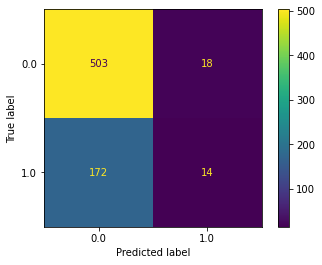

In [31]:
plot_confusion_matrix(ensemble, X_test, y_test) 

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.97      0.84       521
         1.0       0.44      0.08      0.13       186

    accuracy                           0.73       707
   macro avg       0.59      0.52      0.48       707
weighted avg       0.66      0.73      0.65       707



In [33]:
train_df[train_df['Disease'] ==1].shape

(82658, 17)

In [34]:
class SecondStageProcessing:
    def __init__(self, traindf, testdf):
        self.traindf = traindf
        self.testdf = testdf
        
    def prcoessing(self):
        new_df = self.traindf.copy()
        test_df = self.testdf.copy()
        X_train_2ndStage = new_df.copy()
        X_train_2ndStage = X_train_2ndStage[X_train_2ndStage['Disease']==1]
        X_train_2ndStage['label'] = 0
        X_train_2ndStage.loc[(X_train_2ndStage['Arr'] == 0) & (X_train_2ndStage['AF'] == 1), 'label'] = 0
        X_train_2ndStage.loc[(X_train_2ndStage['Arr'] == 1) & (X_train_2ndStage['AF'] == 0), 'label'] = 1
        X_train_2ndStage = X_train_2ndStage.drop(columns=['AF', 'Arr', 'Disease'])
        X_test_2ndStage = test_df.copy()
        X_test_2ndStage = X_test_2ndStage[X_test_2ndStage['Disease']==1]
        X_test_2ndStage['label'] = 0
        X_test_2ndStage.loc[(X_test_2ndStage['Arr'] == 0) & (X_test_2ndStage['AF'] == 1), 'label'] = 0
        X_test_2ndStage.loc[(X_test_2ndStage['Arr'] == 1) & (X_test_2ndStage['AF'] == 0), 'label'] = 1
        self.traindf = X_train_2ndStage
        self.testdf = X_test_2ndStage
        return self.traindf, self.testdf
    
    # remving outliers using Isolation Forest
    def OutlierRemoval(self):
        train_df, X_test_df = self.prcoessing()
        data = train_df.to_numpy()
        X , y = data[:, :-1], data[:, -1]

        iso = IsolationForest(contamination=0.1)
        yhat = iso.fit_predict(X)
        # select all rows that are not outliers
        mask = yhat != -1
        afterX, aftery = X[mask, :], y[mask]
        unhealthy_df_no_outliers = pd.DataFrame(afterX,  columns = train_df.drop(columns=['label']).columns)
        unhealthy_df_no_outliers['label'] = aftery
        unhealthy_df_no_outliers['AF'] = 0
        unhealthy_df_no_outliers['Arr'] = 0
        unhealthy_df_no_outliers.loc[(unhealthy_df_no_outliers['label'] == 0), 'AF'] = 1
        unhealthy_df_no_outliers.loc[(unhealthy_df_no_outliers['label'] == 1), 'Arr'] = 1
        self.traindf = unhealthy_df_no_outliers
        return self.traindf, self.testdf 

    def DataAugmentation(self):
        train_df, X_test_df = self.OutlierRemoval()
        arr_x = train_df.loc[:,train_df.columns != 'Arr']
        arr_y = train_df['Arr']
        AF_data = train_df.drop(columns=['Arr'], axis=1) # data with only the AF label
        Arr_data = train_df.drop(columns=['AF'], axis=1) # data with only the Arr label
        arr_smote_x = Arr_data.loc[:,Arr_data.columns != 'Arr']
        arr_smote_y = Arr_data['Arr']

        oversample_arr = SMOTE(sampling_strategy='auto')
        arr_smote_x, arr_smote_y = oversample_arr.fit_resample(arr_smote_x, arr_smote_y)
        af_smote_x = AF_data.loc[:,AF_data.columns != 'AF']
        af_smote_y = AF_data['AF']

        oversample_af = SMOTE(sampling_strategy='auto')
        af_smote_x, af_smote_y = oversample_af.fit_resample(af_smote_x, af_smote_y)
        arr_smote_x['Arr'] = arr_smote_y
        af_smote_x['AF'] = af_smote_y
        AF_only = af_smote_x[af_smote_x['AF'] == 1] # data with only positive labels of AF
        Arr_only = arr_smote_x[arr_smote_x['Arr'] ==1] # data with only positive labels of Arr
        with_smote_df = pd.concat([Arr_only,AF_only])
        
        with_smote_df.loc[(with_smote_df['Arr'] == 1) & (with_smote_df['AF'] == 0), 'label'] = 1
        with_smote_df.loc[(with_smote_df['Arr'] == 0) & (with_smote_df['AF'] == 1), 'label'] = 0
        self.df = with_smote_df
        return self.df, X_test_df

       
    def finalCleanedDf(self):
        new_df, X_test_df = self.DataAugmentation()
        
        new_df.loc[(new_df['label'] == 0), 'AF'] = 1
        new_df.loc[(new_df['label'] == 0), 'Arr'] = 0
        new_df.loc[(new_df['label'] == 1), 'Arr'] = 1
        new_df.loc[(new_df['label'] == 1), 'AF'] = 0
        self.df = new_df
        return self.df, X_test_df

In [35]:
instance = SecondStageProcessing(train_df, test_df)
train2_df, test2_df= instance.finalCleanedDf()

In [36]:
X2_train = train2_df.drop(columns=['eid', 'AF', 'Arr', 'label'])
y2_train = train2_df['label']

X_test = test2_df.drop(columns=['eid', 'AF', 'Arr', 'Disease', 'label'])
y_test = test2_df['label']


In [37]:
train2_df['label'].value_counts()

0.0    38440
1.0    38440
Name: label, dtype: int64

In [38]:

estimators = []

model1 = xgb.XGBClassifier(objective='binary:logistic', subsample=0.75,  
                          n_estimators=100, colsample_bytree = 0.99, learning_rate = 1,
                max_depth = 10,  gamma=5, alpha = 1, seed=123, use_label_encoder=False, eval_metric='error')

estimators.append(('XGBoost', model1))
estimators.append(('bayes', GaussianNB()))
estimators.append(('GradientDescent' , SGDClassifier(loss="modified_huber", penalty="elasticnet", max_iter=500)))
ensemble = VotingClassifier(estimators, voting = 'soft')


In [39]:
ensemble.fit(X2_train, y2_train)
y_pred_2 = ensemble.predict(X_test)

In [40]:
y_test.value_counts()

0    169
1     17
Name: label, dtype: int64

In [41]:
Counter(y_pred_2)

Counter({1.0: 139, 0.0: 47})

In [42]:
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred_2)
print('f1_score: %.3f' % f1_score)
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_2)
print('Precision: %.3f' % precision)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_2, average='binary')
print('Recall: %.3f' % recall)

f1_score: 0.179
Precision: 0.101
Recall: 0.824


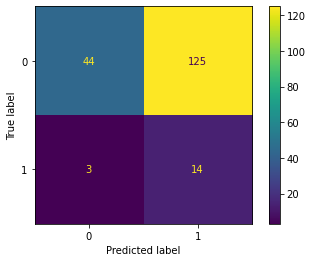

In [43]:
plot_confusion_matrix(ensemble, X_test, y_test) 

In [44]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.94      0.26      0.41       169
           1       0.10      0.82      0.18        17

    accuracy                           0.31       186
   macro avg       0.52      0.54      0.29       186
weighted avg       0.86      0.31      0.39       186

